In [4]:
import os
import sys
import shutil
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import kagglehub
import zipfile

# --- 1. CONFIGURATION AND SETUP ---
# General settings
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Training settings
INITIAL_EPOCHS = 20
FINE_TUNE_EPOCHS = 30
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

# --- 2. GPU VERIFICATION ---
print("--> Verifying GPU availability...")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        details = tf.config.experimental.get_device_details(gpus[0])
        print(f"     ✅ SUCCESS: Found GPU: {details.get('device_name', 'Unknown')}")
    except RuntimeError as e:
        print(e)
else:
    print("     ❌ FAILURE: No GPU found.")
    sys.exit()

# --- 3. UTILITY FUNCTIONS (CORRECTED FOR KAGGLEHUB) ---
def download_and_unzip_with_kagglehub(dataset_handle, target_dir):
    """
    Downloads a dataset from Kaggle using kagglehub and copies it to the target directory.
    """
    if os.path.exists(target_dir) and os.listdir(target_dir):
        print(f"--> Dataset in '{target_dir}' already found locally.")
        return

    print(f"\n--> Downloading and preparing dataset '{dataset_handle}'...")
    dataset_path = kagglehub.dataset_download(dataset_handle)
    
    print(f"    -> Copying dataset from {dataset_path} to '{target_dir}'...")
    # CORRECTED: Added dirs_exist_ok=True to prevent the FileExistsError
    shutil.copytree(dataset_path, target_dir, dirs_exist_ok=True)
    
    print(f"     ✅ Dataset preparation complete for {target_dir}.")


def split_data(source_dir, train_dir, val_dir, test_dir, split_ratios=(0.7, 0.15, 0.15)):
    """Splits data from a source directory into train, validation, and test sets."""
    if os.path.exists(train_dir) and os.listdir(train_dir):
        print(f"     Data already split for {os.path.basename(source_dir)}. Skipping split.")
        return

    os.makedirs(train_dir, exist_ok=True); os.makedirs(val_dir, exist_ok=True); os.makedirs(test_dir, exist_ok=True)
    
    files = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]
    random.shuffle(files)

    train_split = int(len(files) * split_ratios[0])
    val_split = int(len(files) * (split_ratios[0] + split_ratios[1]))

    for f in files[:train_split]: shutil.copy(os.path.join(source_dir, f), os.path.join(train_dir, f))
    for f in files[train_split:val_split]: shutil.copy(os.path.join(source_dir, f), os.path.join(val_dir, f))
    for f in files[val_split:]: shutil.copy(os.path.join(source_dir, f), os.path.join(test_dir, f))
    print(f"     Split {len(files)} images from {os.path.basename(source_dir)} into train/val/test.")

# --- 4. DATA PREPARATION ---
# Using the corrected download function
download_and_unzip_with_kagglehub('ashishmotwani/tomato', 'tomato_dataset_unzipped')
download_and_unzip_with_kagglehub('puneet6060/intel-image-classification', 'intel_image_dataset_unzipped')

# --- 4.1. Prepare data for BINARY classifier ---
print("\n--> Preparing data for the binary 'Tomato Leaf Detector' model...")
binary_base_dir = 'binary_classifier_data'
binary_train_dir = os.path.join(binary_base_dir, 'train'); binary_val_dir = os.path.join(binary_base_dir, 'val'); binary_test_dir = os.path.join(binary_base_dir, 'test')
tomato_leaf_dir = os.path.join(binary_base_dir, 'source', 'tomato_leaf'); not_tomato_leaf_dir = os.path.join(binary_base_dir, 'source', 'not_tomato_leaf')
os.makedirs(tomato_leaf_dir, exist_ok=True); os.makedirs(not_tomato_leaf_dir, exist_ok=True)

# CORRECTED PATH: Removed extra '/tomato/' and changed 'Tomato_healthy' to 'healthy'
tomato_source_dir = os.path.join('tomato_dataset_unzipped', 'train', 'healthy')
if not os.listdir(tomato_leaf_dir):
    for i, fname in enumerate(os.listdir(tomato_source_dir)):
        if i >= 2000: break
        shutil.copy(os.path.join(tomato_source_dir, fname), os.path.join(tomato_leaf_dir, fname))

intel_forest_dir = os.path.join('intel_image_dataset_unzipped', 'seg_train', 'seg_train', 'forest')
intel_street_dir = os.path.join('intel_image_dataset_unzipped', 'seg_train', 'seg_train', 'street')
if not os.listdir(not_tomato_leaf_dir):
    for i, fname in enumerate(os.listdir(intel_forest_dir)):
        if i >= 1000: break
        shutil.copy(os.path.join(intel_forest_dir, fname), os.path.join(not_tomato_leaf_dir, fname))
    for i, fname in enumerate(os.listdir(intel_street_dir)):
        if i >= 1000: break
        shutil.copy(os.path.join(intel_street_dir, fname), os.path.join(not_tomato_leaf_dir, f"street_{fname}"))

split_data(tomato_leaf_dir, os.path.join(binary_train_dir, 'tomato_leaf'), os.path.join(binary_val_dir, 'tomato_leaf'), os.path.join(binary_test_dir, 'tomato_leaf'))
split_data(not_tomato_leaf_dir, os.path.join(binary_train_dir, 'not_tomato_leaf'), os.path.join(binary_val_dir, 'not_tomato_leaf'), os.path.join(binary_test_dir, 'not_tomato_leaf'))

binary_train_ds = tf.keras.utils.image_dataset_from_directory(binary_train_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE)
binary_val_ds = tf.keras.utils.image_dataset_from_directory(binary_val_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE)
binary_test_ds = tf.keras.utils.image_dataset_from_directory(binary_test_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False)

# --- 4.2. Prepare data for MULTI-CLASS classifier ---
print("\n--> Preparing data for the multi-class 'Disease Recognizer' model...")
disease_base_dir = 'disease_classifier_data'
disease_train_dir = os.path.join(disease_base_dir, 'train'); disease_val_dir = os.path.join(disease_base_dir, 'val'); disease_test_dir = os.path.join(disease_base_dir, 'test')
# CORRECTED PATH: Removed extra '/tomato/'
tomato_classes_source_dir = os.path.join('tomato_dataset_unzipped', 'train') 

for class_name in os.listdir(tomato_classes_source_dir):
    class_source_path = os.path.join(tomato_classes_source_dir, class_name)
    if os.path.isdir(class_source_path):
        split_data(class_source_path, os.path.join(disease_train_dir, class_name), os.path.join(disease_val_dir, class_name), os.path.join(disease_test_dir, class_name))

disease_train_ds = tf.keras.utils.image_dataset_from_directory(disease_train_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='categorical')
disease_val_ds = tf.keras.utils.image_dataset_from_directory(disease_val_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='categorical')
disease_test_ds = tf.keras.utils.image_dataset_from_directory(disease_test_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False, label_mode='categorical')

class_names = disease_train_ds.class_names
with open('class_names.txt', 'w') as f:
    for item in class_names:
        f.write(f"{item}\n")
print("     ✅ Disease class names saved to class_names.txt")


# --- 5. MODEL ARCHITECTURE & TRAINING (WITH OVERFITTING PREVENTION) ---
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath='tomato_disease_recognizer_best.keras', save_best_only=True, monitor='val_loss', verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
]

def create_disease_model():
    base_model = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = False
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = tf.keras.applications.resnet_v2.preprocess_input(x)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(len(class_names), activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    model = tf.keras.Model(inputs, outputs, name='resnet50v2_disease_recognizer')
    return model, base_model

def train_and_evaluate_model(model, base_model, train_ds, val_ds):
    print("--- Phase 1: Initial Training (Top Layers) ---")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_ds, validation_data=val_ds, epochs=INITIAL_EPOCHS, callbacks=callbacks_list)

    print("\n--- Phase 2: Fine-Tuning (Unfreezing Base Model Layers) ---")
    base_model.trainable = True
    fine_tune_at = -50
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    history_fine_tune = model.fit(train_ds, validation_data=val_ds, epochs=TOTAL_EPOCHS, initial_epoch=len(history.epoch), callbacks=callbacks_list)

    history.history['accuracy'].extend(history_fine_tune.history['accuracy'])
    history.history['val_accuracy'].extend(history_fine_tune.history['val_accuracy'])
    history.history['loss'].extend(history_fine_tune.history['loss'])
    history.history['val_loss'].extend(history_fine_tune.history['val_loss'])
    return model, history

print("\n--> Training the disease recognizer model: ResNet50V2...")
resnet_model, resnet_base = create_disease_model()
resnet_model, history = train_and_evaluate_model(resnet_model, resnet_base, disease_train_ds, disease_val_ds)
print("     ✅ Training complete. Best model was saved to tomato_disease_recognizer_best.keras")


# --- 6. EVALUATION ---
print("\n--- MODEL EVALUATION ON TEST SET (USING BEST SAVED MODEL) ---")
best_model = tf.keras.models.load_model('tomato_disease_recognizer_best.keras')

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}'); plt.ylabel('Actual'); plt.xlabel('Predicted'); plt.tight_layout(); plt.show()

y_true = np.concatenate([y for x, y in disease_test_ds], axis=0)
y_true_indices = np.argmax(y_true, axis=1)

print("\n--- ResNet50V2 Performance ---")
preds = best_model.predict(disease_test_ds)
pred_indices = np.argmax(preds, axis=1)

print(classification_report(y_true_indices, pred_indices, target_names=class_names))
plot_confusion_matrix(y_true_indices, pred_indices, "ResNet50V2")

final_accuracy = np.mean(tf.keras.metrics.categorical_accuracy(y_true, preds))
print(f"\nFinal Test Accuracy - ResNet50V2: {final_accuracy:.2%}")


# --- 7. PLOT TRAINING HISTORY ---
acc = history.history['accuracy']; val_acc = history.history['val_accuracy']
loss = history.history['loss']; val_loss = history.history['val_loss']

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy'); plt.plot(val_acc, label='Validation Accuracy')
if len(history.epoch) < TOTAL_EPOCHS and len(history.epoch) > 0:
    plt.axvline(x=len(history.epoch)-1, color='grey', linestyle=':', label='Start Fine-Tuning')
plt.legend(loc='lower right'); plt.title('ResNet50V2 Training and Validation Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss'); plt.plot(val_loss, label='Validation Loss')
if len(history.epoch) < TOTAL_EPOCHS and len(history.epoch) > 0:
    plt.axvline(x=len(history.epoch)-1, color='grey', linestyle=':', label='Start Fine-Tuning')
plt.legend(loc='upper right'); plt.title('ResNet50V2 Training and Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.tight_layout(); plt.show()

--> Verifying GPU availability...
     ✅ SUCCESS: Found GPU: Tesla T4
--> Dataset in 'tomato_dataset_unzipped' already found locally.
--> Dataset in 'intel_image_dataset_unzipped' already found locally.

--> Preparing data for the binary 'Tomato Leaf Detector' model...
     Split 2000 images from tomato_leaf into train/val/test.
     Split 2000 images from not_tomato_leaf into train/val/test.
Found 2800 files belonging to 2 classes.


I0000 00:00:1759117773.195616      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759117773.196285      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 600 files belonging to 2 classes.
Found 600 files belonging to 2 classes.

--> Preparing data for the multi-class 'Disease Recognizer' model...
     Split 2039 images from Tomato_Yellow_Leaf_Curl_Virus into train/val/test.
     Split 3051 images from healthy into train/val/test.
     Split 1004 images from powdery_mildew into train/val/test.
     Split 1747 images from Spider_mites Two-spotted_spider_mite into train/val/test.
     Split 2455 images from Early_blight into train/val/test.
     Split 3113 images from Late_blight into train/val/test.
     Split 2754 images from Leaf_Mold into train/val/test.
     Split 1827 images from Target_Spot into train/val/test.
     Split 2153 images from Tomato_mosaic_virus into train/val/test.
     Split 2882 images from Septoria_leaf_spot into train/val/test.
     Split 2826 images from Bacterial_spot into train/val/test.
Found 18090 files belonging to 11 classes.
Found 3878 files belonging to 11 classes.
Found 3883 files belonging to 11 cl

I0000 00:00:1759117794.461151     107 cuda_dnn.cc:529] Loaded cuDNN version 90300


566/566 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.4688 - loss: 1.6276
Epoch 1: val_loss improved from inf to 0.92602, saving model to tomato_disease_recognizer_best.keras
566/566 ━━━━━━━━━━━━━━━━━━━━ 90s 134ms/step - accuracy: 0.4690 - loss: 1.6269 - val_accuracy: 0.7099 - val_loss: 0.9260 - learning_rate: 0.0010
Epoch 2/20
565/566 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.7027 - loss: 0.9344
Epoch 2: val_loss improved from 0.92602 to 0.83793, saving model to tomato_disease_recognizer_best.keras
566/566 ━━━━━━━━━━━━━━━━━━━━ 81s 143ms/step - accuracy: 0.7027 - loss: 0.9343 - val_accuracy: 0.7465 - val_loss: 0.8379 - learning_rate: 0.0010
Epoch 3/20
565/566 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.7229 - loss: 0.8694
Epoch 3: val_loss improved from 0.83793 to 0.77056, saving model to tomato_disease_recognizer_best.keras
566/566 ━━━━━━━━━━━━━━━━━━━━ 81s 143ms/step - accuracy: 0.7230 - loss: 0.8693 - val_accuracy: 0.7679 - val_loss: 0.7706 - learning_rate: 0.0010
Epoc

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]] [Op:IteratorGetNext] name: 

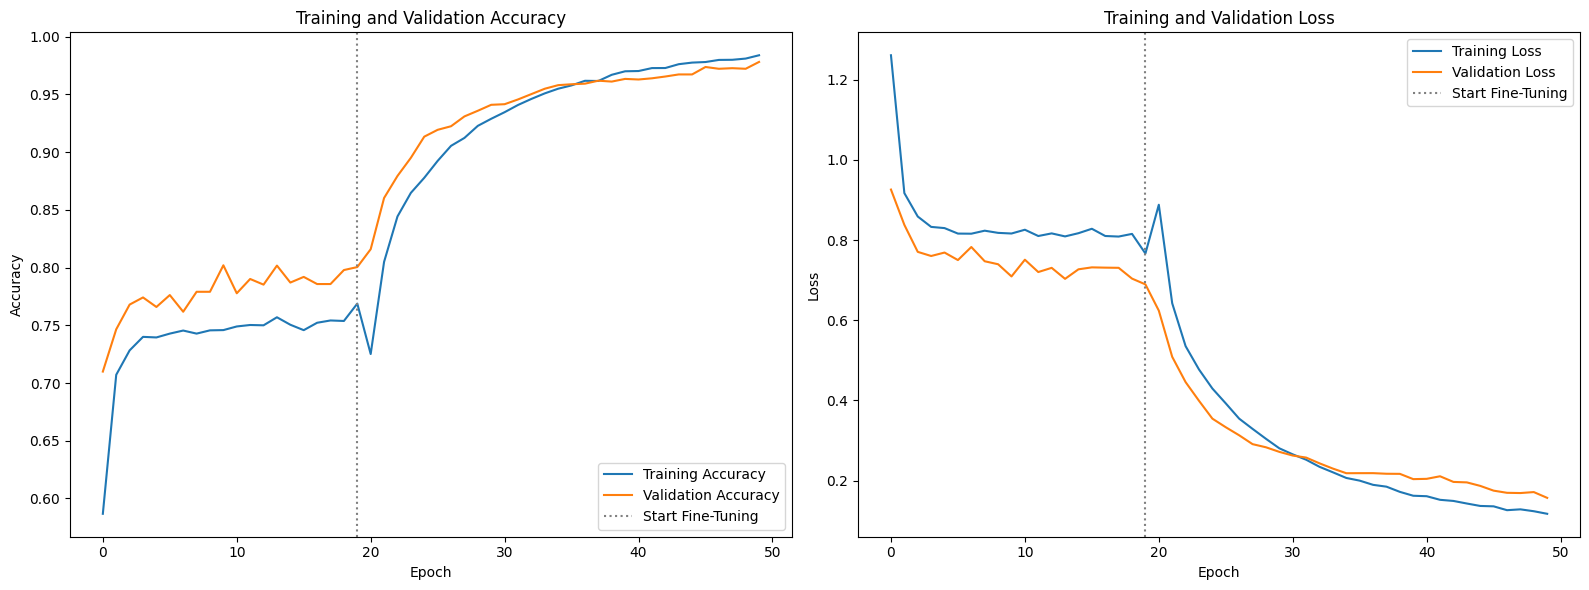

In [5]:
import matplotlib.pyplot as plt

# --- 1. EXTRACT DATA FROM THE HISTORY OBJECT ---
# The 'history' object should be the one returned by the final model.fit() call
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Define the number of initial epochs before fine-tuning started
# This is needed to draw the vertical line correctly.
INITIAL_EPOCHS = 20 
TOTAL_EPOCHS = len(acc) # Total epochs that actually ran

# --- 2. CREATE THE PLOTS ---
plt.figure(figsize=(16, 6))

# Plot for Training & Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')

# Add a vertical line to show the start of fine-tuning
if TOTAL_EPOCHS > INITIAL_EPOCHS:
    plt.axvline(x=INITIAL_EPOCHS - 1, color='grey', linestyle=':', label='Start Fine-Tuning')

plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot for Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

# Add a vertical line to show the start of fine-tuning
if TOTAL_EPOCHS > INITIAL_EPOCHS:
    plt.axvline(x=INITIAL_EPOCHS - 1, color='grey', linestyle=':', label='Start Fine-Tuning')

plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# --- 3. DISPLAY THE PLOTS ---
plt.tight_layout() # Adjusts plot parameters for a tight layout
plt.show()

In [7]:
# --- 1. INSTALL THE LIBRARY ---
# This library allows us to interact with the Google Drive API
!pip install PyDrive2

# --- 2. AUTHENTICATE WITH GOOGLE ---
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

print("✅ Authentication successful.")


# --- 3. UPLOAD THE MODEL FILE 📤 ---
# Define the local path to your saved model and the desired filename in Drive
local_file_path = '/kaggle/working/tomato_disease_recognizer_best.keras'
drive_filename = 'tomato_disease_recognizer_best.keras'

# Create a GoogleDriveFile instance with the desired filename
file_to_upload = drive.CreateFile({'title': drive_filename})

# Set the content of the file to your local model file
file_to_upload.SetContentFile(local_file_path)

# Execute the upload
file_to_upload.Upload()

print(f"✅ Successfully uploaded '{file_to_upload['title']}' to Google Drive.")
print(f"File ID: {file_to_upload['id']}")

✅ Authentication successful.
✅ Successfully uploaded 'tomato_disease_recognizer_best.keras' to Google Drive.
File ID: 1mBNK5ydLiUELsKHz3C54S-rrhsIvLYzw
